# Importing libraries

In [101]:
import numpy as np
from sklearn import datasets
from torchvision.datasets import CIFAR10
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import copy
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import recall_score, accuracy_score
import numpy as np
import pandas as pd
import io
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib import image as mpimg

In [102]:
torch.manual_seed(42)


# Importing Dataset

In [103]:
data_dir = '/kaggle/input/satellite-image-classification/data'
labels = os.listdir(data_dir)
labels

['cloudy', 'desert', 'green_area', 'water']

# Finding no. of images in each class

In [104]:
# Number of Images for each class label
for label in labels:
    print(label, len(os.listdir(data_dir+'/'+label)))

cloudy 1500
desert 1131
green_area 1500
water 1500


# Finding total images count

In [105]:
label_counts = {}
li=[]
for label in labels:
    label_dir = os.path.join(data_dir, label)
    lx=os.listdir(label_dir)
    img=os.path.join(label_dir, lx[0])
    
    li.append([label,img])
    num_images = len(os.listdir(label_dir))
    label_counts[label] = num_images

total_count = sum(label_counts.values())
print("Total image count:", total_count)
print(li)

Total image count: 5631
[['cloudy', '/kaggle/input/satellite-image-classification/data/cloudy/train_17406.jpg'], ['desert', '/kaggle/input/satellite-image-classification/data/desert/desert(14).jpg'], ['green_area', '/kaggle/input/satellite-image-classification/data/green_area/Forest_2838.jpg'], ['water', '/kaggle/input/satellite-image-classification/data/water/SeaLake_926.jpg']]


# displaying 1 image from each label

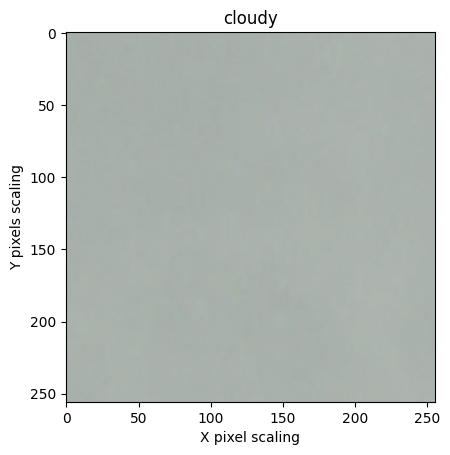

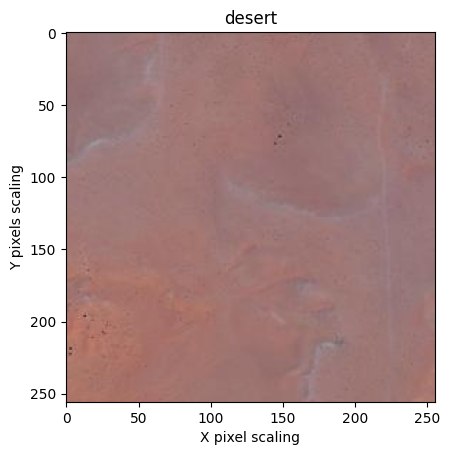

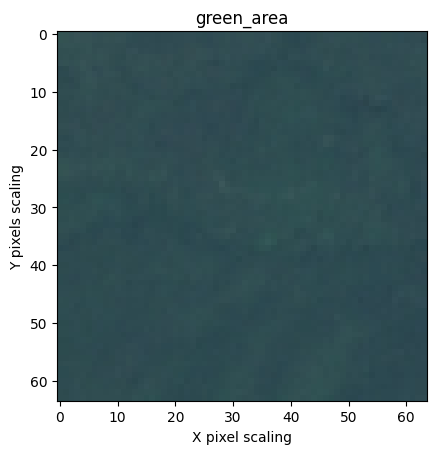

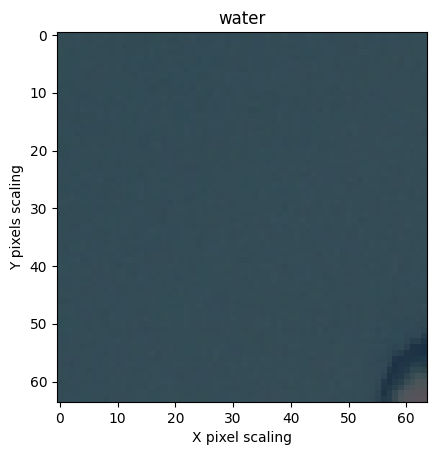

In [106]:
x=[]
for i in li:
    img=i[1]
    x.append(img)
    plt.title(i[0])
    plt.xlabel("X pixel scaling")
    plt.ylabel("Y pixels scaling")
    image = mpimg.imread(img)
    plt.imshow(image)
    plt.show()

# Deciding the parameters

In [107]:
img_width, img_height = 299,299
target_size = (img_width,img_height)
batch_size = 32
input_shape = (img_height, img_height, 3)
num_label =4
epoch =10

# Creating and splitting datset 

In [108]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformation for data augmentation
data_transforms = transforms.Compose([
    transforms.RandomRotation(10),            # Random rotation (degrees)
    transforms.RandomHorizontalFlip(),        # Random horizontal flip
    transforms.RandomVerticalFlip(),          # Random vertical flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
    transforms.RandomResizedCrop(size=target_size),  # Random resized crop
    transforms.ToTensor(),                    # Convert PIL Image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Load training dataset with augmentation
train_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)

# Split dataset into training and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# No augmentation for testing
test_transforms = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load test dataset
test_dataset = datasets.ImageFolder(root=data_dir, transform=test_transforms)
# Create test data loader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Displaying imafges form each label

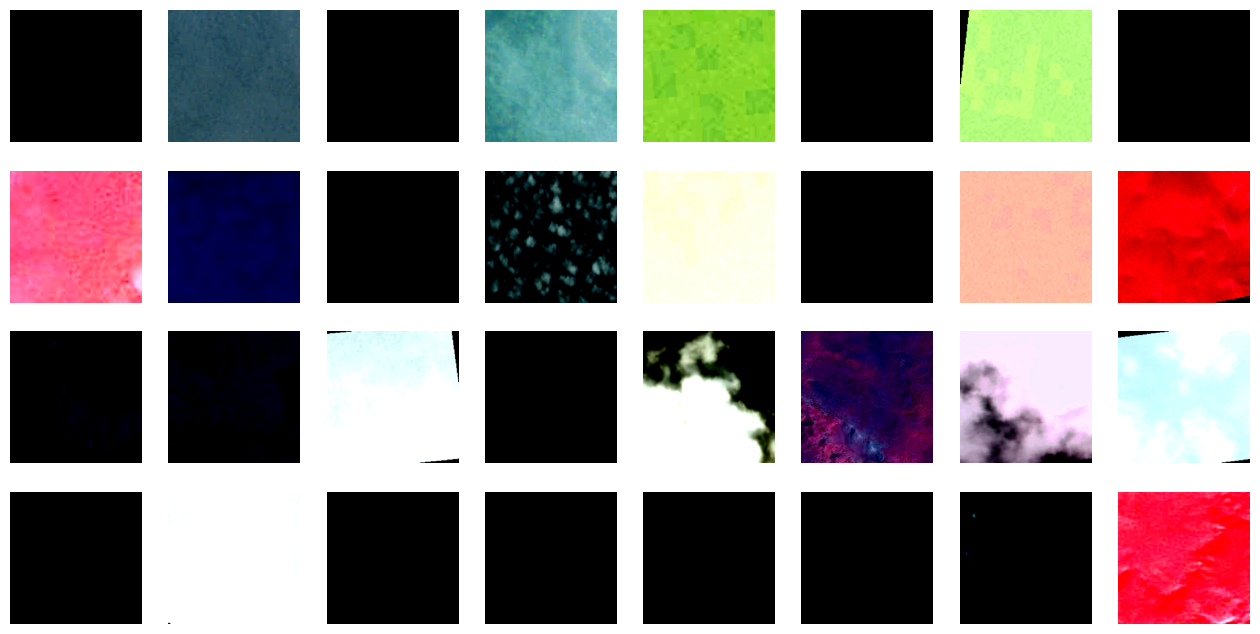

In [110]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of sample images from the data loader
images, _ = next(iter(train_loader))

# Display the images
fig, ax = plt.subplots(nrows=4, ncols=8, figsize=(16, 8))
for i in range(32):
    image = images[i].permute(1, 2, 0)  # Permute dimensions for displaying with matplotlib
    ax.flatten()[i].imshow(image)
    ax.flatten()[i].axis('off')
plt.show()


# Importing inceptionnet-v3 and freezing the top layers 

In [120]:
# Set the device to use (GPU if available, else CPU)
device ="cuda"

# Assuming even roll number, using InceptionNet-v3
model = models.inception_v3(pretrained=True)

# Freeze all layers except the last one
for param in model.parameters():
    param.requires_grad = False

# Replace the last linear layer with a new one
num_classes = 4 
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to the device
model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

# Trainign the model 

In [121]:
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())  # Optimizing all parameters of the model

losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        # Pass images through the model to get logits
        outputs = model(images)
        
        # Extract logits from InceptionOutputs object
        logits = outputs.logits  # Assuming InceptionV3 outputs logits directly
        
        # Compute loss using logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


Epoch [1/10], Loss: 0.6545
Epoch [2/10], Loss: 0.3485
Epoch [3/10], Loss: 0.2827
Epoch [4/10], Loss: 0.2665
Epoch [5/10], Loss: 0.2545
Epoch [6/10], Loss: 0.2372
Epoch [7/10], Loss: 0.2513
Epoch [8/10], Loss: 0.2358
Epoch [9/10], Loss: 0.2356
Epoch [10/10], Loss: 0.2122


# Training loss curve

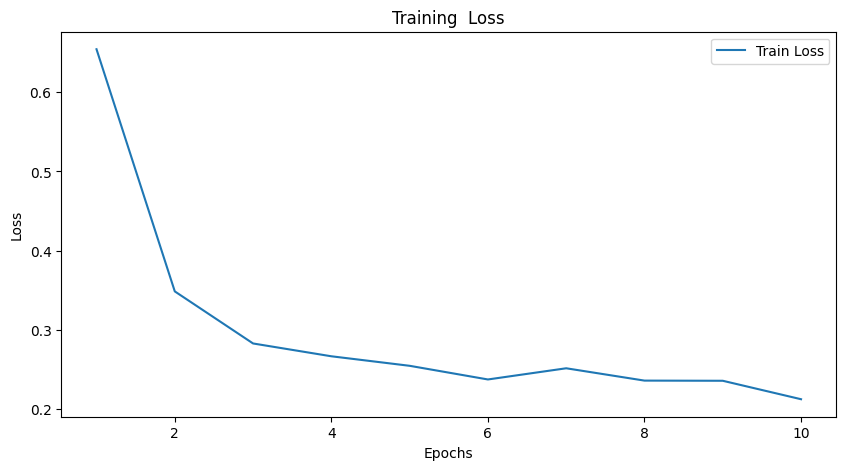

In [132]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1),losses, label='Train Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training  Loss')
plt.legend()
plt.show()



# Defining the function to evaluate the model performance

In [134]:
def calculate_metrics(model, dataloader):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    recall = recall_score(true_labels, predictions, average='macro')
    accuracy = accuracy_score(true_labels, predictions)
    
    return recall, accuracy


# Finding the accuracy and recall

In [135]:
recall_finetuned, accuracy_finetuned = calculate_metrics(model, test_loader)
print(f"Fine-tuned Model - Recall: {recall_finetuned:.4f}, Accuracy: {accuracy_finetuned:.4f}")


Fine-tuned Model - Recall: 0.9644, Accuracy: 0.9634


# Functions to create and display salint maps

In [116]:
from PIL import Image
def generate_saliency_maps(model, image, target_class):
    model.eval()
    image = image.unsqueeze(0).to(device)
    image.requires_grad_()

    output = model(image)
    _, predicted_class = torch.max(output, 1)

    loss = -output[0, target_class]

    model.zero_grad()
    loss.backward()

    gradients = image.grad.data

    # Compute saliency map
    saliency_map = gradients.abs().max(dim=1)[0]

    return saliency_map.squeeze().cpu().numpy()

def plot_saliency_map(image, saliency_map):
    plt.subplot(1, 2, 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(saliency_map, cmap='hot')
    plt.axis('off')
    plt.title('Saliency Map')

    plt.show()


# Taking images from each class and displaying salient maps sidewise

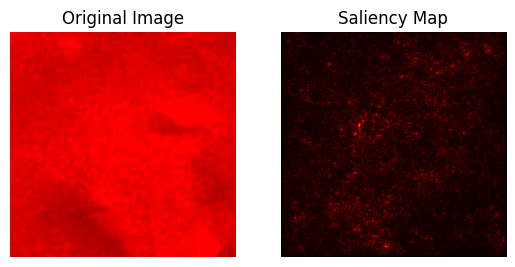

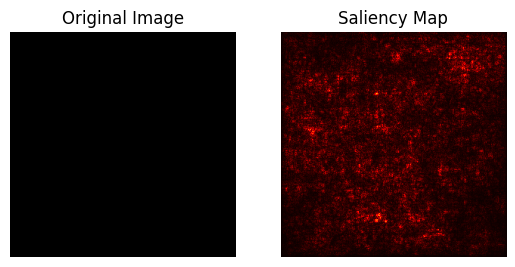

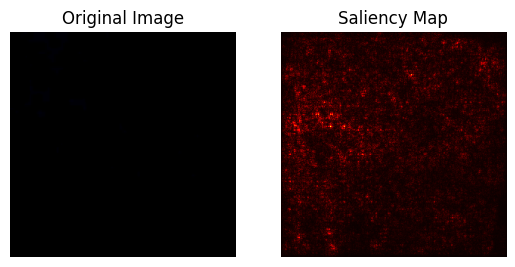

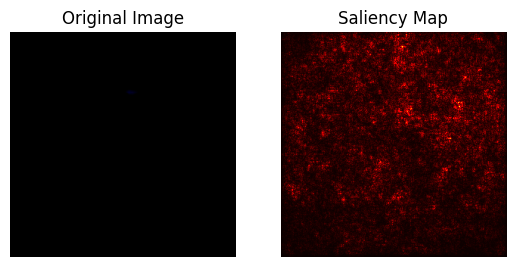

In [118]:
for class_index, image in class_images.items():
    
    saliency_map = generate_saliency_maps(model, image, class_index)
    plot_saliency_map(image, saliency_map)

# Re-train the entire network

In [137]:

for param in model.parameters():
    param.requires_grad = True

# Re-Training on the same datset

In [138]:
num_epochs = 10

losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        # Pass images through the model to get logits
        outputs = model(images)
        
        # Extract logits from InceptionOutputs object
        logits = outputs.logits  # Assuming InceptionV3 outputs logits directly
        
        # Compute loss using logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


Epoch [1/10], Loss: 0.3179
Epoch [2/10], Loss: 0.2020
Epoch [3/10], Loss: 0.2061
Epoch [4/10], Loss: 0.1616
Epoch [5/10], Loss: 0.1036
Epoch [6/10], Loss: 0.0905
Epoch [7/10], Loss: 0.0981
Epoch [8/10], Loss: 0.0858
Epoch [9/10], Loss: 0.0794
Epoch [10/10], Loss: 0.0941


# Re-training loss curve

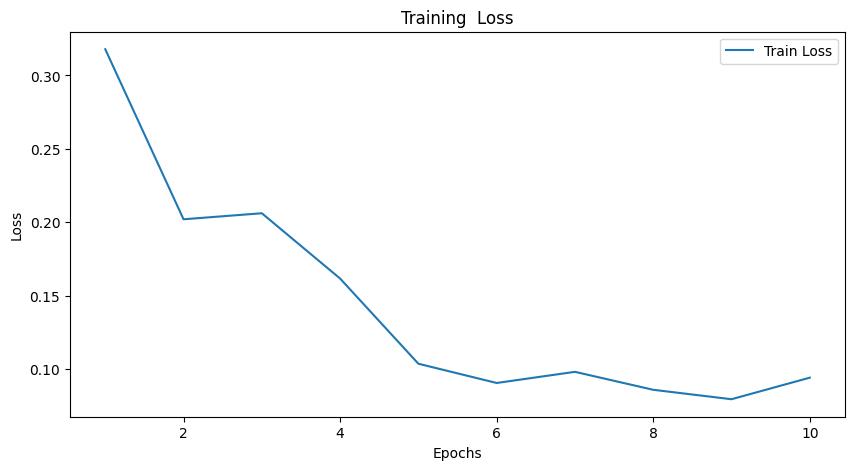

In [139]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1),losses, label='Train Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training  Loss')
plt.legend()
plt.show()



# Finding accuracy of re-trained model

In [140]:
recall_finetuned, accuracy_finetuned = calculate_metrics(model, test_loader)
print(f"Fine-tuned Model - Recall: {recall_finetuned:.4f}, Accuracy: {accuracy_finetuned:.4f}")


Fine-tuned Model - Recall: 0.9828, Accuracy: 0.9817


# Plotting Salient maps using re-trained model

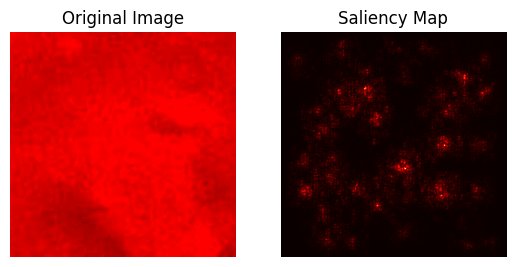

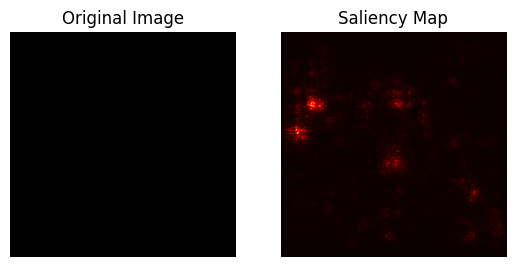

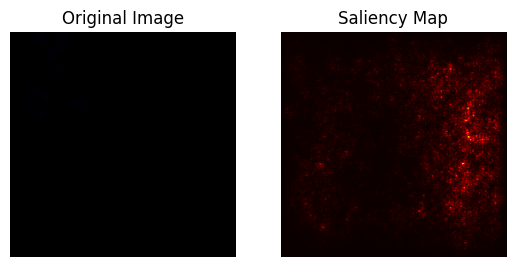

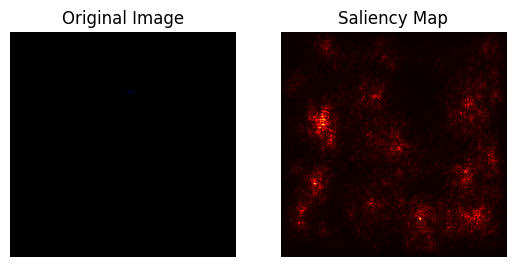

In [147]:
for class_index, image in class_images.items():
    
    saliency_map = generate_saliency_maps(model, image, class_index)
    plot_saliency_map(image, saliency_map)

# Regarding the difference in metric values between the fine-tuned and re-trained models:

**1: Fine-tuning only the last layer allows the model to adapt to the new dataset while leveraging the pre-trained features from the earlier layers. This can be effective if the new dataset is similar to the dataset used for pre-training.**
 
**2: Re-training the entire network allows the model to learn features specific to the new dataset from scratch. This can be beneficial if the new This can be beneficial if the new dataset is substantially different from the dataset used for pre-training, or if the task at hand requires learning completely different representations. By retraining the entire network, the model has the flexibility to adjust all parameters according to the new data distribution potentially leading to better adaptation to the new task or domain.**

**Conclusion :**
*The re-trainined model gives more accurate result for the same dataset*
